In [1]:
import keras
from keras.layers import LSTM, Dense, Embedding
from keras.preprocessing import sequence
import os
import numpy as np

C:\Users\junaid\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
data_dir = "C:/Users/junaid/MyNotebooks/DeepLearningChapter6/climate_data"
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
f = open(fname)
data = f.read()
f.close()

In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:] #remove header

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [5]:
float_data = np.zeros((len(lines), len(header) - 1)) #rows x columns

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]] #remove date from line
    float_data[i, :] = values

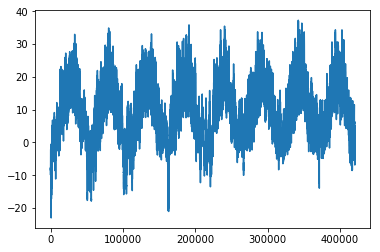

In [6]:
import matplotlib.pyplot as plt

temp = float_data[:, 1] # rows x columns, after remove date from float_data, 1 index column contains temperature in celsius
plt.plot(range(len(temp)), temp)
plt.show()

In [7]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Now here is the data generator that we will use. It yields a tuple (samples, targets) where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:

1. data: The original array of floating point data, which we just normalized in the code snippet above.
2. lookback: How many timesteps back should our input data go.
3. delay: How many timesteps in the future should our target be.
4. min_index and max_index: Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another one for testing.
5. shuffle: Whether to shuffle our samples or draw them in chronological order.
6. batch_size: The number of samples per batch.
7. step: The period, in timesteps, at which we sample data. We will set it 6 in order to draw one data point every hour.

In [51]:
def data_generator(data, look_back, delay, min_index, max_index, shuffle=False, batch_size=128, step_size=6):
    if max_index is None:
        max_index = len(data) - delay - 1
        
    i = min_index + look_back
    
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + look_back, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + look_back
            rows = np.arrange(i, min(i + batch_size, max_index))
            i += len(rows)
            
            print(i)
        
        samples = np.zeros((len(rows), look_back // step, data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - look_back, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

In [55]:
look_back = 1440 # 10 days
delay = 144 # 1 day
batch_size = 128

data_generator(float_data, look_back, delay, 0, 200000)
train_data = (200000 - 0 - look_back) // batch_size

train_data

1551